In [7]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
qutip.about()

print(qutip.settings)

from itertools import permutations
import random
import itertools


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.0.4
Numpy Version:      2.1.2
Scipy Version:      1.14.1
Cython Version:     None
Matplotlib Version: 3.9.2
Python Version:     3.12.3
Number of CPUs:     8
BLAS Info:          Generic
INTEL MKL Ext:      False
Platform Info:      Darwin (arm64)
Installation path:  /Users/chenscheim/PycharmProjects/QEC_A/myenv/lib/python3.12/site-packages/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference

In [8]:
I = identity(2)
Z = sigmaz()
up1 = basis(2, 0)
down1 = basis(2, 1)

# Single-qubit Hamiltonians
H3 =  tensor(Z, Z, Z)
H2 =  tensor(Z, Z, I) + tensor(I, Z, Z) + tensor(Z,I,Z)

ID3 = tensor(I,I,I)
H = ID3 + H3 + ID3 + H2

eigenvalues, eigenstates = H.eigenstates()

basis_labels = ['|000⟩', '|001⟩', '|010⟩', '|011⟩', '|100⟩', '|101⟩', '|110⟩', '|111⟩']

print("Eigenvalues of the Hamiltonian:", eigenvalues)
for i, state in enumerate(eigenstates):
    if eigenvalues[i] == np.min(eigenvalues):
        min_eigenstate = state
        
        components = state.full().flatten()
        for i, component in enumerate(components):
            if np.abs(component) > 1e-6:
                spin_state = basis_labels[i]
                print(f"Spin state: {spin_state}")


Eigenvalues of the Hamiltonian: [0. 0. 0. 2. 2. 2. 4. 6.]
Spin state: |001⟩
Spin state: |010⟩
Spin state: |100⟩


https://arxiv.org/pdf/quant-ph/0007071

In [4]:
def generate_random_clause(n):
    """
    Generates a random clause for EC3 by selecting three distinct bits (0-based indices).
    n: Number of bits.
    """
    return tuple(random.sample(range(n), 3))

def is_clause_satisfied(clause, assignment):
    """
    Checks if a given clause is satisfied by the assignment.
    A clause is satisfied if exactly one of the three bits is 1.
    """
    return sum(assignment[i] for i in clause) == 1

def find_satisfying_assignments(n, clauses):
    """
    Finds all satisfying assignments for the given clauses.
    n: Number of bits.
    clauses: List of clauses (each clause is a tuple of three distinct bit indices).
    Returns a list of all assignments (as tuples) that satisfy all clauses.
    """
    satisfying_assignments = []
    all_assignments = itertools.product([0, 1], repeat=n)  # Generate all 2^n possible assignments
    
    for assignment in all_assignments:
        if all(is_clause_satisfied(clause, assignment) for clause in clauses):
            satisfying_assignments.append(assignment)
    
    return satisfying_assignments

def generate_ec3_instance(n):
    """
    Generates a valid EC3 instance with n bits, such that there is exactly one satisfying assignment.
    """
    clauses = []
    
    while True:
        # Add a random clause
        new_clause = generate_random_clause(n)
        clauses.append(new_clause)
        
        # Find satisfying assignments
        satisfying_assignments = find_satisfying_assignments(n, clauses)
        
        # If there's exactly one satisfying assignment, accept the instance
        if len(satisfying_assignments) == 1:
            return clauses, satisfying_assignments[0]  # Return the clauses and the satisfying assignment
        
        # If there are no satisfying assignments, reject the instance and start over
        if len(satisfying_assignments) == 0:
            clauses = []  # Reset the clauses and try again

Unique satisfying bitstring: 0100
Generated EC3 clauses (n=4):
(3, 2, 1)
(1, 2, 0)
(0, 2, 1)
(2, 1, 0)
(3, 1, 2)
(3, 1, 0)
Energy diff is:  0.5863622197102965
Energy spectrum at beginning:  [0, 3, 4, 5, 6, 7, 8, 9, 9, 10, 11, 12, 13, 14, 15, 18]
Energy spectrum at end:  [1, 2, 3, 4, 5, 6, 7]


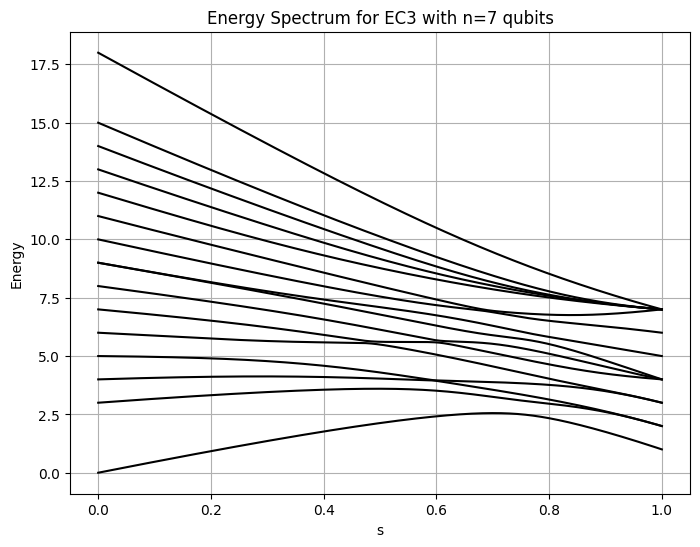

4
Solution bitstring (EC3 solution): 0100


In [5]:
# Number of qubits
n_qubits = 4

clauses, satisfying_assignment = generate_ec3_instance(n_qubits)

# unique_solution = generate_random_solution(n_qubits)
# print(unique_solution)
# clauses = generate_unique_ec3_instance(n_qubits, 3, unique_solution)

print(f"Unique satisfying bitstring: {''.join(map(str, satisfying_assignment))}")

print(f"Generated EC3 clauses (n={n_qubits}):")
for clause in clauses:
    print(clause)
    

# Define single-qubit Pauli-X and Identity matrices
I = qeye(2)
I_7 = tensor([I for _ in range(n_qubits)])
X = sigmax()
Z = sigmaz()

def H_B(clauses):
    H_b = Qobj(qzero(2**n_qubits))
    for (i, j, k) in clauses:
        H_b += 0.5 * Qobj(((I_7 - tensor([X if x == i else I for x in range(n_qubits)])) + 
                  (I_7 - tensor([X if x == j else I for x in range(n_qubits)])) +
                  (I_7 - tensor([X if x == k else I for x in range(n_qubits)]))).data, dims=H_b.dims)
    return H_b

def check_clause_violation(state_binary, clause):
    i, j, k = clause
    bits = [state_binary[i], state_binary[j], state_binary[k]]
    return sum(bits) != 1

def cost_function(z, clauses):
    bitstring = f"{z:0{n_qubits}b}"
    bit_values = [int(b) for b in bitstring] 

    violations = 0
    for clause in clauses:
        if check_clause_violation(bit_values, clause):
            violations += 1  # Clause is violated

    return violations

# Problem Hamiltonian H_P
def H_P(clauses):
    H_p = qeye(2**n_qubits)
    for z in range(2**n_qubits):
        state = basis(2**n_qubits, z)

        h_z = cost_function(z, clauses)
        projector_z = state * state.dag()
        
        H_p += h_z * projector_z
    return H_p

def H_t(s, Hp, Hb):
    return (1 - s) * Hb + s * Hp

def H_C_calc(t, args):
    H_c = Qobj(qzero(2**n_qubits))
    s = t / args['t_max']
    for clause in args['clauses']:
        H_B_C = H_B([clause])
        H_B_P = H_P([clause])
        H_c += H_B_C*(1 - s) + H_B_P*s
    return H_c
    
s_values = np.linspace(0, 1, 1000)
Hb = H_B(clauses)
Hp = H_P(clauses)

energy_diff = None
# Calculate the energy spectrum
energy_spectrum = []
for s in s_values:
    H = H_t(s, Hp, Hb)
    energies = H.eigenenergies()
    energy_spectrum.append(energies)
    
    eg_inst = energies[1] - energies[0]
    if not energy_diff:
        energy_diff = eg_inst
    if energy_diff > eg_inst:
        energy_diff = eg_inst

print("Energy diff is: ", energy_diff)

energy_spectrum = np.array(energy_spectrum)
# Plot the energy spectrum
plt.figure(figsize=(8, 6))
for i in range(2**n_qubits):
    plt.plot(s_values, energy_spectrum[:, i], color='black')
    
print("Energy spectrum at beginning: ", [int(np.round(i)) for i in energy_spectrum[0]])
print("Energy spectrum at end: ", [int(np.round(i)) for i in set(energy_spectrum[-1])])


plt.xlabel('s')
plt.ylabel('Energy')
plt.title('Energy Spectrum for EC3 with n=7 qubits')
plt.grid(True)
plt.show()


# Ground state of Hb at the beginning of the protocol
eigenvalues_initial, eigenstates_initial = Hb.eigenstates()
initial_gs = eigenstates_initial[0]
# Ground state of Hp at the ending of the protocol
eigenvalues_final, eigenstates_final = Hp.eigenstates()
final_gs = eigenstates_final[0]

omega_ba = eigenvalues_final[0] - eigenvalues_initial[0]

solution_bitstring_index = np.argmax(np.abs(final_gs.full()))
print(solution_bitstring_index)
solution_bitstring = f"{solution_bitstring_index:0{n_qubits}b}"

print(f"Solution bitstring (EC3 solution): {solution_bitstring}")

# Checking if the GS is the unique assignment

In [6]:
def bose_einstein_distribution(energy_diff, temperature):
    if temperature == 0:
        return 0
    return 1 / (np.exp(energy_diff / (temperature)) - 1)

def gab(omega1, omega2, lambda_2):
    if omega1 >= omega2:
        return 0
    return np.sqrt(lambda_2)

def H_s_t(t, args):
    s = t / args['t_max']
    return (1 - s) * args['Hb'] + s * args['Hp']
  
def c_ops_gen(t, args):
    """
    Robustness of adiabatic quantum computation - from this paper
    :param t: time parameter 
    :param args: dictionary of optional arguments
    :return: a matrix of the collapse operator
    """
    H_inst_t = H_s_t(t, args['args_H'])
    eigenvalues_a, eigenstates_a = H_inst_t.eigenstates()
    eigenvalues_b, eigenstates_b = H_inst_t.eigenstates()
    
    # c_ops_n = []
    # for i in range(args['n_qubits']):
    sigmam_i = args['sigma_i']
    c_ops = Qobj(qzero(2**args['n_qubits']).data, dims=H_inst_t.dims)
    for omega_a, a in zip(eigenvalues_a, eigenstates_a):
        for omega_b, b in zip(eigenvalues_b, eigenstates_b):
            mat_el = b * a.dag()
            if np.abs(omega_a-omega_b) < 1e-10:
                continue
            if np.round(omega_b) > np.round(omega_a):
                Nba = bose_einstein_distribution(omega_b-omega_a, args['T'])
                g_ba = gab(omega_a, omega_b, args['lambda_2'])                    
                ma = a.dag() * sigmam_i * b * b.dag() * sigmam_i.dag() * a
                factor = (Nba * (g_ba**2) * ma)
                c_ops += factor * mat_el

            if np.round(omega_a) > np.round(omega_b):
                Nab = bose_einstein_distribution(omega_a-omega_b, args['T'])
                g_ab = gab(omega_b, omega_a, args['lambda_2'])
                ma = b.dag() * sigmam_i * a * a.dag() * sigmam_i.dag() * b
                factor = (Nab + 1) * (g_ab**2) * ma
                c_ops += factor * mat_el
                    
        # c_ops_n.append(c_ops)
    # return c_ops_n[0]
    return 0.5 * c_ops

def rho_P(T):
    eigenvalues, eigenstates = Hp.eigenstates()
    Z = np.sum([np.exp(-ev / T) for ev in eigenvalues])
    # Thermal density matrix
    return sum([np.exp(-eigenvalues[i] / T) * eigenstates[i] * eigenstates[i].dag() for i in range(len(eigenstates))]) / Z

# Plotting sesolve for 5 different E gaps

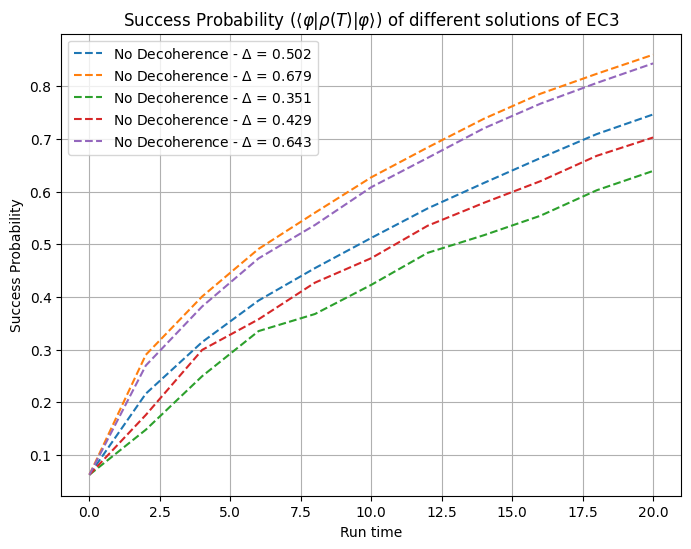

In [10]:
E_gaps = []
s_values = np.linspace(0, 1, 100)

t_fs = np.linspace(0, 20, 11)
tf_iters = 100

w = lambda t, args: 1 - (t / int(np.max(times)))
f = lambda t, args: (t / int(np.max(times)))

rho0 = initial_gs * initial_gs.dag()

plt.figure(figsize=(8, 6))

while len(E_gaps) <= 4:
    clauses, satisfying_assignment = generate_ec3_instance(n_qubits)

    Hb = H_B(clauses)
    Hp = H_P(clauses)
    
    energy_diff = None
    for s in s_values:
        H = H_t(s, Hp, Hb)
        energies = H.eigenenergies()
        
        eg_inst = energies[1] - energies[0]
        if not energy_diff:
            energy_diff = eg_inst
        if energy_diff > eg_inst:
            energy_diff = eg_inst
    
    energy_diff = round(energy_diff,3)
    if energy_diff not in E_gaps:
        E_gaps.append(energy_diff)

        eigenvalues_final, eigenstates_final = Hp.eigenstates()
        final_gs = eigenstates_final[0]

        H_obj = [[Hb, w], [Hp, f]]    
        exps_se = []
        for ind, tf in enumerate(t_fs[1:]):
            times = np.linspace(0, tf, tf_iters)
            results = sesolve(H_obj, initial_gs, times)
        
            states = results.states
            if ind == 0:
                exps_se.append(expect(ket2dm(states[0]), final_gs))    
            exps_se.append(expect(ket2dm(states[-1]), final_gs))
        
        plt.plot(t_fs, exps_se, '--', label=r"No Decoherence - $\Delta$ = " + str(energy_diff), linewidth=1.5)
        

# Plot formatting
plt.xlabel('Run time')
plt.ylabel('Success Probability')
plt.title('Success Probability (' + r"$\langle \varphi | \rho(T) | \varphi \rangle$"
          + ') of different solutions of EC3')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
times = np.linspace(0, 20, 11)
s_values = times / max(times)

args_H = {'t_max': int(np.max(times)),
          'Hb': Hb,
          'Hp': Hp
}

lambda_2 = 0.1

temperatures = [1/10, 1/2, 1, 2, 10]
# temperatures = [1/2, 1, 2, 10]

# Initial state (starting in the ground state of H_B)
rho0 = initial_gs * initial_gs.dag()

w = lambda t, args: 1 - (t / int(np.max(times)))
f = lambda t, args: (t / int(np.max(times)))

H_obj = [[Hb, w], [Hp, f]]
H_C_t = QobjEvo(H_C_calc, args={'t_max': int(np.max(times)),
                                'clauses': clauses})

# Target state (ground state of H_P)
rho1 = final_gs * final_gs.dag()

# Solve the master equation for each temperature
plt.figure(figsize=(8, 6))
expects_at_end = []
for T in temperatures:
    print('Working on temp:', T)

    c_ops_s = []
    for i in range(n_qubits):
        args_C = {"args_H": args_H,
                  "n_qubits": n_qubits,
                  "lambda_2":lambda_2,
                  "T":T,
                  "sigma_i": Qobj(tensor([sigmam() if j == i else qeye(2) for j in range(n_qubits)]).data, dims=Hp.dims)
                 }
        c_ops_i = QobjEvo(c_ops_gen, args=args_C)
        c_ops_s.append(c_ops_i)

    # Solve the master equation over time
    results = mesolve(H_C_t, rho0, times, c_ops=c_ops_s, options={'nsteps': 100000})
    # 

    exps = []
    for state_dm in results.states:
        exps.append(expect(state_dm, final_gs))
    plt.plot(times, exps, "-o", label=f"T = {T}")  # Success probability
    
    #thermal success probabilities
    expects_at_end.append(expect(rho_P(T), final_gs))

x_s = [np.max(times) + 0.5 for _ in range(len(temperatures))]
plt.plot(x_s, expects_at_end, '<', color='black')

# results_se = sesolve(lambda t, args: H_s_t(t, args_H), initial_gs, times)
results_se = sesolve(H_C_t, initial_gs, times)
exps_se = []
for state in results_se.states:
    exps_se.append(expect(ket2dm(state), final_gs))
plt.plot(times, exps_se, '--', label="No Decoherence", color='black', linewidth=1.5)

# Plot formatting
plt.xlabel('Run time')
plt.ylabel('Success Probability')
plt.title('Success Probability (' + r"$\langle \varphi | \rho(T) | \varphi \rangle$"
          + ') with Decoherence at Different Temperatures - '
          + r'$\Delta$'
          + ' = {} - '.format(round(energy_diff,3))
          + r'$\lambda^{2}$'
          + ' = {}'.format(lambda_2))
plt.legend()
plt.grid(True)
plt.show()

Working on temp: 0.1


capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
Traceback (most recent call last):
  File "/Users/chenscheim/PycharmProjects/QEC_A/myenv/lib/python3.12/site-packages/qutip/solver/integrator/scipy_integrator.py", line 69, in _mul_np_vec
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
    out = self.system.matmul_data(t, state)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "qutip/core/cy/qobjevo.pyx", line 1105, in qutip.core.cy.qobjevo.QobjEvo.matmul_data
  File "qutip/core/cy/qobjevo.pyx", line 1117, in qutip.core.cy.qobjevo.QobjEvo.matmul_data
  File "qutip/core/cy/_element.pyx", line 619, in qutip.core.cy._element._ProdElement.matmul_data_t
  File "qutip/core/cy/_element.pyx", line 165, in qutip.core.cy._element._BaseElement.matmul_data_t
  File "qutip/core/cy/_element.pyx", line 546, in qutip.core.cy._element._MapElement.data
  File "qutip/core/cy/_element.pyx", lin

In [11]:
def c_ops_gen(t, args):
    """
    Robustness of adiabatic quantum computation - from this paper
    :param t: time parameter 
    :param args: dictionary of optional arguments
    :return: a matrix of the collapse operator
    """
    H_inst_t = H_s_t(t, args['args_H'])
    eigenvalues_a, eigenstates_a = H_inst_t.eigenstates()
    eigenvalues_b, eigenstates_b = H_inst_t.eigenstates()
    
    # c_ops_n = []
    # for i in range(args['n_qubits']):
    sigmam_i = args['sigma_i']
    c_ops = Qobj(qzero(2**args['n_qubits']).data, dims=H_inst_t.dims)
    for omega_a, a in zip(eigenvalues_a, eigenstates_a):
        for omega_b, b in zip(eigenvalues_b, eigenstates_b):
            mat_el = b * a.dag()
            if np.abs(omega_a-omega_b) < 1e-6:
                continue
            if np.round(omega_b) > np.round(omega_a):
                Nba = bose_einstein_distribution(omega_b-omega_a, args['T'])
                g_ba = gab(omega_a, omega_b, args['lambda_2'])                    
                ma = a.dag() * sigmam_i * b * b.dag() * sigmam_i.dag() * a
                factor = (Nba * (g_ba**2) * ma)
                c_ops += factor * mat_el

            if np.round(omega_a) > np.round(omega_b):
                Nab = bose_einstein_distribution(omega_a-omega_b, args['T'])
                g_ab = gab(omega_b, omega_a, args['lambda_2'])
                ma = b.dag() * sigmam_i * a * a.dag() * sigmam_i.dag() * b
                factor = (Nab + 1) * (g_ab**2) * ma
                c_ops += factor * mat_el
                    
        # c_ops_n.append(c_ops)
    # return c_ops_n[0]
    # print(2*c_ops)
    return 10*c_ops

In [ ]:
t_fs = np.linspace(0, 20, 11)
tf_iters = 2

w = lambda t, args: 1 - (t / int(np.max(times)))
f = lambda t, args: (t / int(np.max(times)))
H_obj = [[Hb, w], [Hp, f]]

rho0 = initial_gs * initial_gs.dag()

lambda_2 = 0.1
# temperatures = [1/10, 1/2, 1, 2, 10]
temperatures = [2]

expects_at_end = []
plt.figure(figsize=(8, 6))
for T in temperatures:
    print('Working on temp:', T)
    
    exps_me = []
    for ind, tf in enumerate(t_fs[1:]):
        print('Working on RunTime T =', tf)
        times = np.linspace(0, tf, tf_iters)

        args_H = {'t_max': tf,
                  'Hb': Hb,
                  'Hp': Hp
                 }
        
        c_ops_s = []
        for i in range(n_qubits):
            args_C = {"args_H": args_H,
                      "n_qubits": n_qubits,
                      "lambda_2":lambda_2,
                      "T":T,
                      "sigma_i": Qobj(tensor([sigmam() if j == i else qeye(2) for j in range(n_qubits)]).data, dims=Hp.dims)
                     }
            c_ops_i = QobjEvo(c_ops_gen, args=args_C)
            c_ops_s.append(c_ops_i)
                
        results = mesolve(H_obj, rho0, times, c_ops=c_ops_s, options={'nsteps': 100000})
        # , options={'nsteps': 100000}
        # results = mesolve(H_obj, rho0, times, c_ops=lambda t: c_ops_gen(t, args_H), options={'nsteps': 100000})

        if ind == 0:
            exps_me.append(expect(results.states[0], final_gs))    

        exps_me.append(expect(results.states[-1], final_gs))
    plt.plot(t_fs, exps_me, "-o", label=f"T = {T}")  # Success probability




        
    #thermal success probabilities
    expects_at_end.append(expect(rho_P(T), final_gs))
    
x_s = [np.max(t_fs) + 0.5 for _ in range(len(temperatures))]
plt.plot(x_s, expects_at_end, '<', color='black')

exps_se = []
for ind, tf in enumerate(t_fs[1:]):
    times = np.linspace(0, tf, tf_iters)
    results = sesolve(H_obj, initial_gs, times)

    states = results.states
    
    if ind == 0:
        exps_se.append(expect(ket2dm(states[0]), final_gs))
        
    exps_se.append(expect(ket2dm(states[-1]), final_gs))

plt.plot(t_fs, exps_se, '--', label="No Decoherence", color='black', linewidth=1.5)

# Plot formatting
plt.xlabel('Run time')
plt.ylabel('Success Probability')
plt.title('Success Probability (' + r"$\langle \varphi | \rho(T) | \varphi \rangle$"
          + ') with Decoherence at Different Temperatures - '
          + r'$\Delta$'
          + ' = {} - '.format(round(energy_diff,3))
          + r'$\lambda^{2}$'
          + ' = {}'.format(lambda_2))
plt.legend()
plt.grid(True)
plt.show()

Working on temp: 2
Working on RunTime T = 2.0


# Checking three different ways of calculating the sesolver

Working on temp: 0.1
Working on temp: 0.5
Working on temp: 1
Working on temp: 2
Working on temp: 10


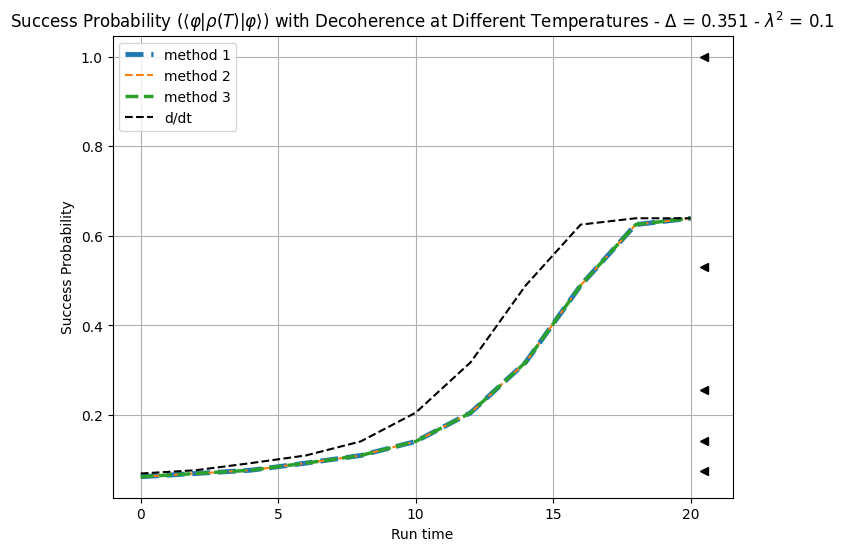

In [10]:
times = np.linspace(0, 20, 11)
s_values = times / max(times)

args_H = {'t_max': int(np.max(times)),
          'Hb': Hb,
          'Hp': Hp
}

lambda_2 = 0.1

temperatures = [1/10, 1/2, 1, 2, 10]
# temperatures = [1/2, 1, 2, 10]

# Initial state (starting in the ground state of H_B)
rho0 = initial_gs * initial_gs.dag()

w = lambda t, args: 1 - (t / int(np.max(times)))
f = lambda t, args: (t / int(np.max(times)))

H_obj = [[Hb, w], [Hp, f]]
H_C_t = QobjEvo(H_C_calc, args={'t_max': int(np.max(times)),
                                'clauses': clauses})
H_s_t = QobjEvo(H_s_t, args=args_H)

# Target state (ground state of H_P)
rho1 = final_gs * final_gs.dag()

# Solve the master equation for each temperature
plt.figure(figsize=(8, 6))
expects_at_end = []
for T in temperatures:
    print('Working on temp:', T)
    #thermal success probabilities
    expects_at_end.append(expect(rho_P(T), final_gs))

x_s = [np.max(times) + 0.5 for _ in range(len(temperatures))]
plt.plot(x_s, expects_at_end, '<', color='black')

# results_se = sesolve(lambda t, args: H_s_t(t, args_H), initial_gs, times)
results_se_1 = sesolve(H_C_t, initial_gs, times)
results_se_2 = sesolve(H_obj, initial_gs, times)
results_se_3 = sesolve(H_s_t, initial_gs, times)

exps_se_1, exps_se_2, exps_se_3 = [], [], []

states_1, states_2, states_3 = results_se_1.states, results_se_2.states, results_se_3.states
for i in range(len(states_1)):
    exps_se_1.append(expect(ket2dm(states_1[i]), final_gs))
    exps_se_2.append(expect(ket2dm(states_2[i]), final_gs))
    exps_se_3.append(expect(ket2dm(states_3[i]), final_gs))

exps_se_dt = []
state_dt = initial_gs
for idx, t_i in enumerate(times[:-1]):
    t_range = [times[idx], times[idx + 1]]
    results_se = sesolve(H_obj, state_dt, t_range)
    state_dt = results_se.states[-1]
    exps_se_dt.append(expect(ket2dm(state_dt), final_gs))
exps_se_dt.append(expect(ket2dm(state_dt), final_gs))

plt.plot(times, exps_se_1, '--', label="method 1", linewidth=3.5)
plt.plot(times, exps_se_2, '--', label="method 2", linewidth=1.5)
plt.plot(times, exps_se_3, '--', label="method 3", linewidth=2.5)
plt.plot(times, exps_se_dt, '--', label="d/dt", color='black', linewidth=1.5)


# Plot formatting
plt.xlabel('Run time')
plt.ylabel('Success Probability')
plt.title('Success Probability (' + r"$\langle \varphi | \rho(T) | \varphi \rangle$"
          + ') with Decoherence at Different Temperatures - '
          + r'$\Delta$'
          + ' = {} - '.format(round(energy_diff,3))
          + r'$\lambda^{2}$'
          + ' = {}'.format(lambda_2))
plt.legend()
plt.grid(True)
plt.show()

# Trying different method with distinct $d/dt$ jumps

In [2]:
def bose_einstein_distribution(energy_diff, temperature):
    if temperature == 0:
        return 0
    return 1 / (np.exp(energy_diff / (temperature)) - 1)

def gab(omega1, omega2, lambda_2):
    if omega1 >= omega2:
        return 0
    return np.sqrt(lambda_2)

def H_s_t(t, args):
    s = t / args['t_max']
    return (1 - s) * args['Hb'] + s * args['Hp']

def c_ops_gen(t, args):
    """
    Robustness of adiabatic quantum computation - from this paper
    :param t: time parameter 
    :param args: dictionary of optional arguments
    :return: a matrix of the collapse operator
    """
    H_inst_t = H_s_t(t, args['args_H'])
    eigenvalues_a, eigenstates_a = H_inst_t.eigenstates()
    eigenvalues_b, eigenstates_b = H_inst_t.eigenstates()
    
    c_ops_lst = []
    for i in range(args['n_qubits']):
        c_ops = Qobj(qzero(2**args['n_qubits']).data, dims=H_inst_t.dims)
        sigmam_i = Qobj(tensor([sigmam() if j == i else qeye(2) for j in range(args['n_qubits'])]).data, dims=H_inst_t.dims)
        for omega_a, a in zip(eigenvalues_a, eigenstates_a):
            for omega_b, b in zip(eigenvalues_b, eigenstates_b):
                mat_el = b * a.dag()
                if np.abs(omega_a-omega_b) < 1e-10:
                    continue
                if np.round(omega_b) > np.round(omega_a):
                    Nba = bose_einstein_distribution(omega_b-omega_a, args['T'])
                    g_ba = gab(omega_a, omega_b, args['lambda_2'])
                    ma = a.dag() * sigmam_i * b * b.dag() * sigmam_i.dag() * a
                    factor = (Nba * (g_ba**2) * ma)
                    c_ops += factor * mat_el
    
                if np.round(omega_a) > np.round(omega_b):
                    Nab = bose_einstein_distribution(omega_a-omega_b, args['T'])
                    g_ab = gab(omega_b, omega_a, args['lambda_2'])        
                    ma = b.dag() * sigmam_i * a * a.dag() * sigmam_i.dag() * b
                    factor = (Nab + 1) * (g_ab**2) * ma
                    c_ops += factor * mat_el
                    
        c_ops_lst.append(c_ops)
                    
    return c_ops_lst

Working on temp: 1
Working on time stemp: 0.0
Working on time stemp: 2.0
Working on time stemp: 4.0
Working on time stemp: 6.0
Working on time stemp: 8.0
Working on time stemp: 10.0
Working on time stemp: 12.0
Working on time stemp: 14.0
Working on time stemp: 16.0
Working on time stemp: 18.0
Working on time stemp: 20.0
[0.06900031274521871, 0.07514350975557371, 0.08867540803808299, 0.10159281823038088, 0.1260401499844389, 0.16970486824703732, 0.24018369145596852, 0.36639589137275247, 0.5446693909466217, 0.6585292724352906, 0.666089724130694]


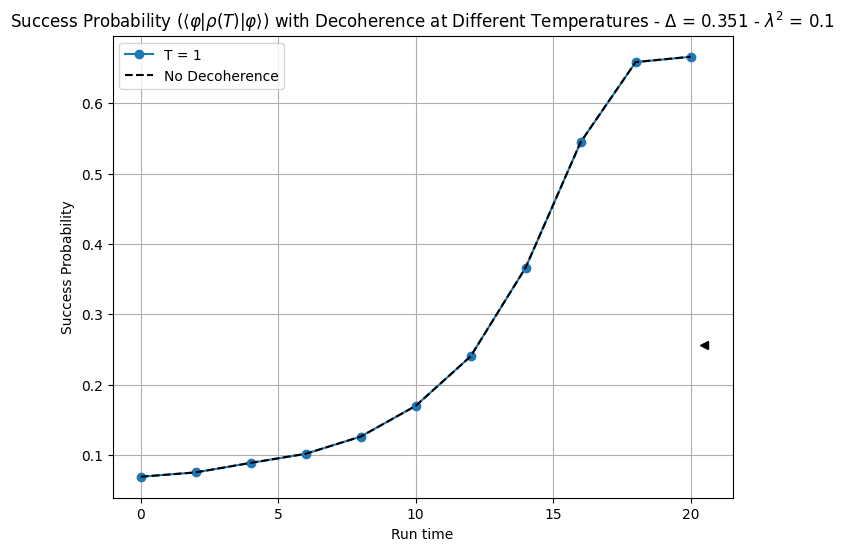

In [103]:
times = np.linspace(0, 22, 12)
s_values = times / max(times)

args_H = {
    't_max': int(np.max(times)),
    'Hb': Hb,
    'Hp': Hp
}

lambda_2 = 1.5

# Temperatures to be considered
temperatures = [1/10, 1/2, 1, 2, 10]
# temperatures = [1]

# Initial state (starting in the ground state of H_B)
rho0 = initial_gs * initial_gs.dag()

# Time-dependent functions for the Hamiltonian
w = lambda t, args: 1 - (t / np.max(times))
f = lambda t, args: t / np.max(times)

# Combined Hamiltonian as a list of tuples
H_obj = [[Hb, w], [Hp, f]]

# Target state (ground state of H_P)
rho1 = final_gs * final_gs.dag()

# Solve the master equation for each temperature
plt.figure(figsize=(8, 6))
expects_at_end = []

for T in temperatures:
    print('Working on temp:', T)
    exps = []
    state_dm = rho0
    
    # Solve the master equation over each time step
    for idx, t_i in enumerate(times[:-1]):
        c_ops_s = []
        for i in range(n_qubits):
            args_C = {"args_H": args_H,
                      "n_qubits": n_qubits,
                      "lambda_2":lambda_2,
                      "T":T,
                      "sigma_i": Qobj(tensor([sigmam() if j == i else I for j in range(n_qubits)]).data, dims=Hp.dims)}
            c_ops_i = QobjEvo(c_ops_gen, args=args_C)
            c_ops_s.append(c_ops_i)
        
        t_range = [times[idx], times[idx + 1]]  # Evolve from t_i to t_i+1
        results = mesolve(H_obj, state_dm, t_range, c_ops=c_ops_s, options={'nsteps': 100000})
        # options={'nsteps': 100000}
        
        # Update the state to the last state in the results
        state_dm = results.states[-1]
        
        # Calculate the expectation value with the final ground state
        exp_val = expect(state_dm, final_gs)
        exps.append(exp_val)

    # Plot the success probability for the current temperature
    plt.plot(times[:-1], exps, "-o", label=f"T = {T}")  # Plot all time points
    
    # Thermal success probabilities
    expects_at_end.append(expect(rho_P(T), final_gs))

x_s = [np.max(times[:-1]) + 0.5 for _ in range(len(temperatures))]
plt.plot(x_s, expects_at_end, '<', color='black')

# Solve the Schrödinger equation without decoherence
exps_se = []
state_dt = initial_gs
for idx, t_i in enumerate(times[:-1]):
    t_range = [times[idx], times[idx + 1]]
    results_se = sesolve(H_obj, state_dt, t_range)
    state_dt = results_se.states[-1]
    exps_se.append(expect(ket2dm(state_dt), final_gs))

print(exps_se)
plt.plot(times[:-1], exps_se, '--', label="No Decoherence", color='black', linewidth=1.5)

# Plot formatting
plt.xlabel('Run time')
plt.ylabel('Success Probability')
plt.title('Success Probability (' + r"$\langle \varphi | \rho(T) | \varphi \rangle$" 
          + ') with Decoherence at Different Temperatures - ' 
          + r'$\Delta$' 
          + ' = {} - '.format(round(energy_diff, 3)) 
          + r'$\lambda^{2}$' 
          + ' = {}'.format(lambda_2))

plt.legend()
plt.grid(True)
plt.show()